# 1. Gerekli Kütüphanelerin Kurulumu ve Kontrolü
Bu aşamada, projenin çalışması için gerekli olan Python kütüphaneleri (`shap`, `xgboost`, `imbalanced-learn` vb.) kontrol edilir. Eğer sistemde yüklü değillerse otomatik olarak indirilir ve kurulur.

In [1]:
import sys
import subprocess
import os

# Gerekli paketleri kontrol et ve yükle
def install_and_check():
    packages = {
        'shap': 'shap',
        'imblearn': 'imbalanced-learn',
        'xgboost': 'xgboost',
        'pandas': 'pandas',
        'numpy': 'numpy',
        'seaborn': 'seaborn',
        'matplotlib': 'matplotlib',
        'sklearn': 'scikit-learn'
    }

    for lib, pip_name in packages.items():
        try:
            __import__(lib)
            print(f"{lib} zaten yüklü.")
        except ImportError:
            print(f"{lib} bulunamadı, yükleniyor ({pip_name})...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
            print(f"{lib} yüklendi.")

install_and_check()


shap zaten yüklü.
imblearn zaten yüklü.
xgboost zaten yüklü.
pandas zaten yüklü.
numpy zaten yüklü.
seaborn zaten yüklü.
matplotlib zaten yüklü.
sklearn zaten yüklü.


# 2. Kütüphanelerin İçe Aktarılması ve Konfigürasyon
Veri analizi, görselleştirme ve makine öğrenmesi modelleri için gerekli tüm kütüphaneler projeye dahil edilir. Ayrıca uyarı mesajlarını kapatma (warnings) ve grafiklerin stil ayarları burada yapılır.

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap 

# Sklearn ve Diğerleri
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Ayarlar
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
os.environ['LOKY_MAX_CPU_COUNT'] = '1' 

print("Tüm kütüphaneler başarıyla yüklendi!")

Tüm kütüphaneler başarıyla yüklendi!


# 3. Veri Yükleme ve Keşifçi Veri Analizi (EDA)
`heart_disease.csv` dosyası pandas ile okunur. Veri setinin genel yapısı incelenir ve hedef değişkenin (`Heart Disease Status`) dağılımı görselleştirilir. Bu adım, veri setindeki dengesizlikleri görmek için kritiktir.

Veri Seti Boyutu: (10000, 21)


,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No



Sınıf Dağılımı:
Heart Disease Status
No     8000
Yes    2000
Name: count, dtype: int64


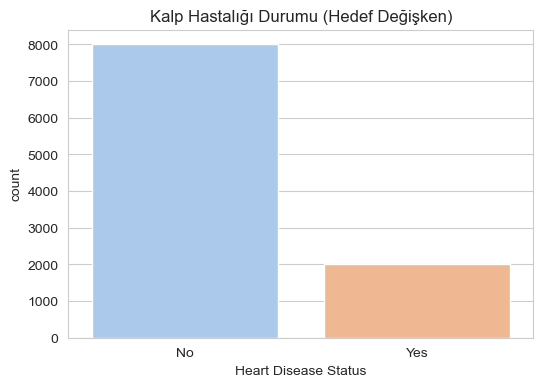

In [3]:

try:
    
    df = pd.read_csv('heart_disease.csv')
    print(f"Veri Seti Boyutu: {df.shape}")
    
    # İlk 5 satırı göster
    display(df.head())
    
    # Hedef Değişken Analizi
    if 'Heart Disease Status' in df.columns:
        print(f"\nSınıf Dağılımı:\n{df['Heart Disease Status'].value_counts()}")
        plt.figure(figsize=(6, 4))
        sns.countplot(x='Heart Disease Status', data=df, palette='pastel')
        plt.title('Kalp Hastalığı Durumu (Hedef Değişken)')
        plt.show()
    else:
        print("UYARI: 'Heart Disease Status' sütunu bulunamadı.")

except FileNotFoundError:
    print("HATA: 'heart_disease.csv' dosyası bulunamadı! Lütfen dosyanın notebook ile aynı klasörde olduğundan emin olun.")

# 4. Özellik Mühendisliği (Feature Engineering)
Mevcut verilerden yeni ve anlamlı özellikler türetilir. Örneğin; sigara, diyabet ve tansiyon gibi risk faktörleri birleştirilerek her hasta için tek bir **'Total_Risk_Score' (Toplam Risk Skoru)** oluşturulur. Bu, modelin başarısını artırmaya yardımcı olur.

In [4]:
# Kopyalama işlemi (Orijinal veriyi bozmamak için)
df_eng = df.copy()

risk_cols = ['Smoking', 'Diabetes', 'High Blood Pressure', 'Family Heart Disease']
existing_risk_cols = [c for c in risk_cols if c in df_eng.columns]

if existing_risk_cols:
    for c in existing_risk_cols:
        # Yes/No -> 1/0 dönüşümü
        df_eng[c + '_num'] = df_eng[c].map({'Yes': 1, 'No': 0})
    
    num_cols = [c + '_num' for c in existing_risk_cols]
    
    # Yeni Özellik: Toplam Risk Skoru
    df_eng['Total_Risk_Score'] = df_eng[num_cols].sum(axis=1)
    
    # Ara sütunları temizle
    df_eng.drop(num_cols, axis=1, inplace=True)
    print("Risk Skoru oluşturuldu.")
    display(df_eng[['Total_Risk_Score']].head())

Risk Skoru oluşturuldu.


,Total_Risk_Score
0,3.0
1,2.0
2,0.0
3,3.0
4,4.0


# 5. Veri Ön İşleme: Encoding ve Eksik Veriler
Makine öğrenmesi modelleri metin verileriyle çalışamaz. Bu nedenle kategorik değişkenler (örn: 'Low', 'High') sayısal değerlere dönüştürülür (Label/Ordinal Encoding). Ayrıca veri setindeki boş/eksik değerler medyan yöntemiyle doldurulur.

In [5]:
target_col = 'Heart Disease Status'

# Hedef değişkeni 1/0 yap
if target_col in df_eng.columns and df_eng[target_col].dtype == 'object':
    df_eng[target_col] = df_eng[target_col].map({'Yes': 1, 'No': 0})

# Sıralı (Ordinal) Değişkenleri Elle Haritalama
ordinal_map = {
    'Exercise Habits': {'Low': 0, 'Medium': 1, 'High': 2},
    'Alcohol Consumption': {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3},
    'Stress Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Sugar Consumption': {'Low': 0, 'Medium': 1, 'High': 2}
}

for col, mapping in ordinal_map.items():
    if col in df_eng.columns:
        df_eng[col] = df_eng[col].map(mapping)

# Diğer kategorik veriler için Label Encoding
le = LabelEncoder()
cat_cols = df_eng.select_dtypes(include=['object']).columns

for col in cat_cols:
    df_eng[col] = le.fit_transform(df_eng[col].astype(str))

# Eksik Verileri Doldurma (Median ile)
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_eng), columns=df_eng.columns)

print("Veri tamamen sayısallaştırıldı ve eksikler dolduruldu.")

Veri tamamen sayısallaştırıldı ve eksikler dolduruldu.


# 6. Eğitim/Test Ayrımı ve Ölçeklendirme
Veri seti, modelin öğrenmesi için **Eğitim (%80)** ve başarısının test edilmesi için **Test (%20)** olarak ikiye ayrılır. Ardından, farklı birimlerdeki verilerin (örn: yaş vs kolesterol) modeli yanıltmaması için standartlaştırma (StandardScaler) işlemi uygulanır.

In [6]:
# Veriyi ayırma
X = df_imputed.drop(target_col, axis=1)
y = df_imputed[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ölçeklendirme (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame'e geri çevirme (Sütun isimlerini korumak için)
X_train = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

Eğitim seti boyutu: (8000, 21)
Test seti boyutu: (2000, 21)


# 7. Dengesiz Veri Çözümü (SMOTE) ve Özellik Seçimi
Kalp hastalığı verileri genellikle dengesizdir (hasta olmayan sayısı daha fazladır). **SMOTE** algoritması ile azınlık sınıfı yapay olarak çoğaltılır. Ardından, aşırı öğrenmeyi (overfitting) önlemek için **Random Forest** kullanılarak en önemli 5 özellik seçilir.

In [7]:
# 1. SMOTE (Dengesiz Veri Çözümü)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"SMOTE Öncesi: {y_train.value_counts().to_dict()}")
print(f"SMOTE Sonrası: {y_train_res.value_counts().to_dict()}")

# 2. Özellik Seçimi (Random Forest ile)
rf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sel.fit(X_train_res, y_train_res)

# Önem derecelerini sırala
importances = pd.Series(rf_sel.feature_importances_, index=X.columns).sort_values(ascending=False)
top_5_feats = importances.head(5).index.tolist()

print(f"\nSeçilen En Önemli 5 Özellik: {top_5_feats}")

# Veriyi sadece bu 5 özelliğe indirge
X_train_final = X_train_res[top_5_feats]
X_test_final = X_test[top_5_feats]

SMOTE Öncesi: {0.0: 6400, 1.0: 1600}
SMOTE Sonrası: {0.0: 6400, 1.0: 6400}

Seçilen En Önemli 5 Özellik: ['Exercise Habits', 'Sugar Consumption', 'Stress Level', 'BMI', 'CRP Level']


# 8. Model Eğitimi ve Hiperparametre Optimizasyonu
Dört farklı algoritma (**Logistic Regression, Random Forest, SVM, XGBoost**) denenir. `GridSearchCV` kullanılarak her model için en iyi parametreler bulunur ve modellerin performansları (F1 Skoru, Doğruluk vb.) karşılaştırılır.

Eğitiliyor: Logistic Regression...
Eğitiliyor: Random Forest...
Eğitiliyor: SVM...
Eğitiliyor: XGBoost...


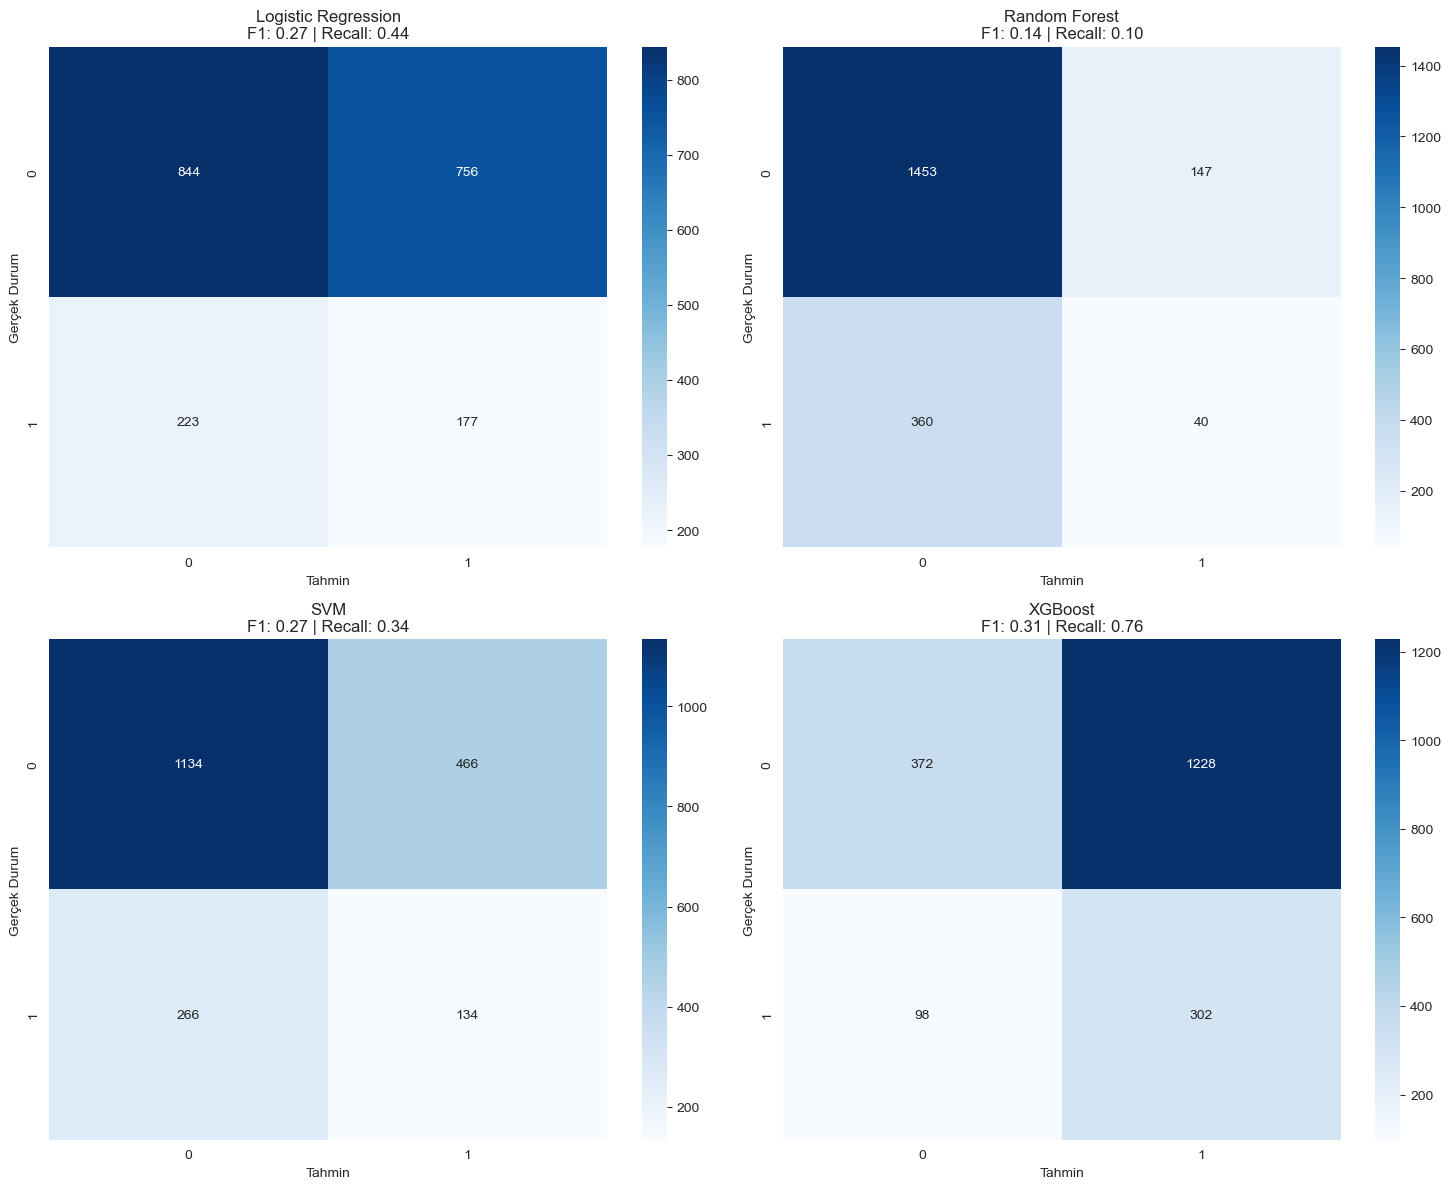


--- Model Sonuçları ---


,Model,F1 Score,Accuracy,Recall,Best Params
3,XGBoost,0.312953,0.3370,0.7550,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."
2,SVM,0.268000,0.6340,0.3350,"{'C': 10, 'kernel': 'rbf'}"
0,Logistic Regression,0.265566,0.5105,0.4425,{'C': 1}
1,Random Forest,0.136286,0.7465,0.1000,"{'max_depth': 20, 'min_samples_leaf': 2, 'n_es..."


In [8]:
# --- HÜCRE 8: MODEL EĞİTİMİ VE KARŞILAŞTIRMA (DÜZELTİLMİŞ) ---

# Dengesizlik Oranını Hesapla (Negatif / Pozitif)
# Bu oran XGBoost'un azınlık sınıfına (Hasta olanlara) daha çok odaklanmasını sağlar.
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [1, 10]}),
    'Random Forest': (RandomForestClassifier(random_state=42), 
                      {'n_estimators': [100], 'max_depth': [10, 20], 'min_samples_leaf': [2]}),
    'SVM': (SVC(probability=True, random_state=42), {'C': [1, 10], 'kernel': ['rbf']}),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight_value), 
                {'learning_rate': [0.1], 'max_depth': [3, 5], 'n_estimators': [100]})
}

results = []
best_models = {}

# Grafik alanı ayarla (4 model için 2x2'lik alan)
plt.figure(figsize=(15, 12))
plot_idx = 1

for name, (model, params) in models.items():
    print(f"Eğitiliyor: {name}...")
    
    # GridSearch ile en iyi parametreleri bul
    clf = GridSearchCV(model, params, cv=3, scoring='f1', n_jobs=1)
    clf.fit(X_train_final, y_train_res)
    
    best = clf.best_estimator_
    best_models[name] = best
    
    # Test seti üzerinde tahmin yap
    y_pred = best.predict(X_test_final)
    
    # Sonuçları Kaydet
    results.append({
        'Model': name,
        'F1 Score': f1_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Best Params': str(clf.best_params_)
    })
    
    # Confusion Matrix Çizimi
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(2, 2, plot_idx)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name}\nF1: {f1_score(y_test, y_pred):.2f} | Recall: {recall_score(y_test, y_pred):.2f}')
    plt.ylabel('Gerçek Durum')
    plt.xlabel('Tahmin')
    plot_idx += 1

plt.tight_layout()
plt.show()

# Sonuç tablosunu yazdır
res_df = pd.DataFrame(results)
print("\n--- Model Sonuçları ---")
display(res_df.sort_values(by='F1 Score', ascending=False))

# 9. Karar Eşiği (Threshold) Optimizasyonu
Standart modeller %50 olasılığın üzerini "Hasta" olarak sınıflandırır. Ancak tıbbi teşhiste "Hasta"yı kaçırmak risklidir. Bu adımda, F1 skorunu maksimize eden en uygun eşik değeri (örneğin %40) bulunur ve Confusion Matrix çizilir.

Eşik       F1         Acc        Recall    
0.20       0.3322     0.2020     0.9925    
0.25       0.3315     0.2115     0.9775    
0.30       0.3305     0.2200     0.9625    
0.35       0.3291     0.2315     0.9425    
0.40       0.3227     0.2485     0.8950    
0.45       0.3215     0.2845     0.8475    
0.50       0.3130     0.3370     0.7550    
0.55       0.3025     0.3960     0.6550    
0.60       0.2766     0.4770     0.5000    
0.65       0.2211     0.6055     0.2800    
0.70       0.1411     0.7260     0.1125    
0.75       0.0441     0.7830     0.0250    
0.80       0.0049     0.7985     0.0025    

OPTİMAL EŞİK: 0.20 -> F1: 0.3322


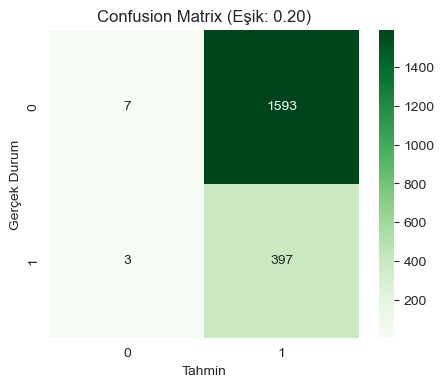

In [9]:
# En iyi modeli seç (Genellikle XGBoost veya RF)
target_model = best_models.get('XGBoost', best_models.get('Random Forest'))
y_prob = target_model.predict_proba(X_test_final)[:, 1]

best_f1 = 0
best_th = 0.5

# 0.20'den 0.80'e kadar eşikleri dene
print(f"{'Eşik':<10} {'F1':<10} {'Acc':<10} {'Recall':<10}")
for th in np.arange(0.2, 0.8, 0.05):
    y_cust = (y_prob >= th).astype(int)
    f1 = f1_score(y_test, y_cust)
    acc = accuracy_score(y_test, y_cust)
    rec = recall_score(y_test, y_cust)
    
    print(f"{th:<10.2f} {f1:<10.4f} {acc:<10.4f} {rec:<10.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_th = th

print(f"\nOPTİMAL EŞİK: {best_th:.2f} -> F1: {best_f1:.4f}")

# Confusion Matrix Çizimi
y_final = (y_prob >= best_th).astype(int)
cm = confusion_matrix(y_test, y_final)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title(f'Confusion Matrix (Eşik: {best_th:.2f})')
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin')
plt.show()

# 10. Model Açıklanabilirliği (SHAP Analizi)
"Model neden bu kararı verdi?" sorusunu yanıtlamak için SHAP (SHapley Additive exPlanations) değerleri kullanılır. Hangi özelliğin (örn: Risk Skoru veya Yaş) kalp hastalığı tahminini ne kadar etkilediği görselleştirilir.

Analiz edilen model: XGBoost


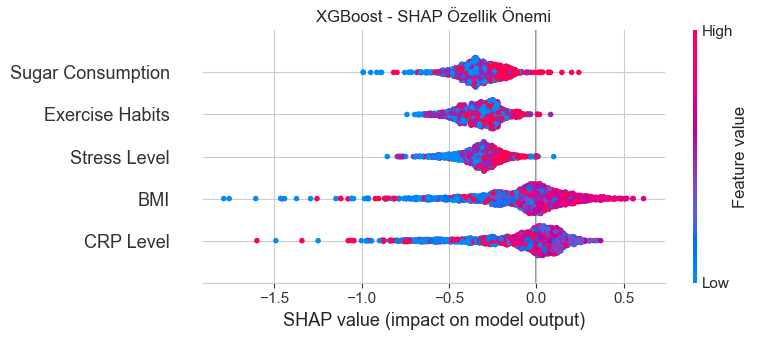

In [10]:
# --- HÜCRE 10: SHAP ANALİZİ (DÜZELTİLMİŞ) ---

# En iyi modeli seç (Genellikle XGBoost veya RF)
target_name = 'XGBoost' if 'XGBoost' in best_models else 'Random Forest'

if target_name in best_models:
    model_to_explain = best_models[target_name]
    print(f"Analiz edilen model: {target_name}")

    try:
        # XGBoost için booster objesini alarak hatayı engelliyoruz
        if target_name == 'XGBoost':
            explainer_obj = model_to_explain.get_booster()
            # Özellik isimlerini geri yükle
            explainer_obj.feature_names = list(X_test_final.columns)
            explainer = shap.TreeExplainer(explainer_obj)
        else:
            # Random Forest için direkt modeli kullanabiliriz
            explainer = shap.TreeExplainer(model_to_explain)
        
        shap_values = explainer.shap_values(X_test_final)
        
        plt.figure(figsize=(10, 8))
        plt.title(f"{target_name} - SHAP Özellik Önemi")
        
        # Eğer shap_values liste dönerse (bazı versiyonlarda) 1. sınıfı al
        if isinstance(shap_values, list):
             shap.summary_plot(shap_values[1], X_test_final, show=True)
        else:
             shap.summary_plot(shap_values, X_test_final, show=True)

    except Exception as e:
        print(f"SHAP oluşturulurken hata oluştu: {e}")
else:
    print("Model bulunamadı. Lütfen önce Hücre 8'i çalıştırın.")